In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 144.6MB 81kB/s 
     |████████████████████████████████| 61kB 3.2MB/s 
ERROR: earthengine-api 0.1.258 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [ ]:
# imports pytorch
import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b2389841-8687-f22d-fc6a-c221bdeff6b8)


In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=0bae1581b21c78a1681a07e826e5b2211542f3daabd29507e753bfb7d36b49ef
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
!cp drive/MyDrive/Study/NewsClassification/images.zip images.zip

In [ ]:
!unzip -q -d . images.zip

In [ ]:
import os
import time
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

FOLDER = 'images'
data_path = 'drive/MyDrive/Study/NewsClassification'
output_path = 'drive/MyDrive/Study/NewsClassification'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
df = pd.read_csv(f"{data_path}/train.csv")

In [ ]:
def get_filenames_with_labels(dataframe):
    images_filenames = []
    images_labels = []
    for index, row in dataframe.iterrows():
        row_images = row['images']
        if isinstance(row_images, str):
            row_filenames = row_images.split(',')
            images_filenames += row_filenames
            images_labels += [row['source'] if 'source' in row else ''] * len(row_filenames)
    return images_filenames, images_labels

In [ ]:
images_filenames, images_labels = get_filenames_with_labels(df)
test_filenames, test_labels = get_filenames_with_labels(pd.read_csv(f"{data_path}/test_without_target.csv"))

In [ ]:
class ImageClassifierDataSet(Dataset):
    def __init__(self, transform, directory, filenames, labels):
        self.transform = transform
        self.directory = directory
        self.filenames = filenames
        self.labels = labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        return self.transform(Image.open(os.path.join(self.directory, self.filenames[index])).convert("RGB")), self.labels[index]

In [ ]:
def split_nth(splitee, nth):
    bigger_part = []
    for index in range(nth - 1):
        bigger_part += splitee[index + 1::nth]
    return splitee[0::nth], bigger_part

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_filenames, train_filenames = split_nth(images_filenames, 5)
val_labels, train_labels = split_nth(images_labels, 5)

trainset = ImageClassifierDataSet(transform, FOLDER, train_filenames, train_labels)
train_sampler = torch.utils.data.distributed.DistributedSampler(
    trainset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
trainloader = DataLoader(trainset, batch_size=8, sampler=train_sampler, num_workers=8)

valset = ImageClassifierDataSet(transform, FOLDER, val_filenames, val_labels)
val_sampler = torch.utils.data.distributed.DistributedSampler(
    valset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)
valloader = DataLoader(valset, batch_size=8, sampler=val_sampler, shuffle=False, num_workers=8)

fullset = ImageClassifierDataSet(transform, FOLDER, images_filenames, images_labels)
full_sampler = torch.utils.data.distributed.DistributedSampler(
    fullset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)
fullloader = DataLoader(fullset, batch_size=8, sampler=full_sampler, shuffle=False, num_workers=8)

testset = ImageClassifierDataSet(transform, FOLDER, test_filenames, test_labels)
test_sampler = torch.utils.data.distributed.DistributedSampler(
    testset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)
testloader = DataLoader(testset, batch_size=8, sampler=test_sampler, shuffle=False, num_workers=8)

NameError: ignored

In [ ]:
import torch_xla.distributed.parallel_loader as pl
def epoch_phase(model, dataloader, criterion, optimizer, scheduler=None):
    dataloader = pl.ParallelLoader(dataloader, [device]).per_device_loader(device)
    phase_start = time.time()
    if scheduler is None:
        model.eval()
    else:
        model.train()
    running_loss = 0.0
    for index, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(scheduler is not None):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            if scheduler is not None:
                loss.backward()
                xm.optimizer_step(optimizer)
        running_loss += loss.item() * inputs.size(0)
        phase_time_left = time.time() - phase_start
        print(f'\r{"Val" if scheduler is None else "Train"} {index}/{len(dataloader)} for {int(phase_time_left)}/{int(phase_time_left / (index + 1) * len(dataloader))}s', end='')
    if scheduler is not None:
        scheduler.step()

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'{"Val" if scheduler is None else "Train"} Loss: {epoch_loss}')
    return epoch_loss

In [ ]:
def train(model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=1):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        epoch_phase(model, trainloader, criterion, optimizer, scheduler)
        val_loss = epoch_phase(model, valloader, criterion, optimizer)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model, output_path + f'/image_model_{int(time.time())}.pth')
    return model

In [ ]:
def prepare_and_train(trainloader, valloader, model, num_epochs):
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.00025, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
    return train(model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs)

In [ ]:
# model = torch.load(f'{output_path}/image_model_1617054602.pth', map_location=torch.device('cpu'))
# model = xm.send_cpu_data_to_device(model, device)

In [ ]:
def get_mean(tensors=None):
    if tensors is not None:
        tensor = torch.FloatTensor(tensors)
        return (tensor.sum(dim=0) / tensor.size(0)).tolist()

In [ ]:
def form_training_outputs(dataframe_path):
    test_df = pd.read_csv(dataframe_path)
    filenames, labels = get_filenames_with_labels(test_df)
    testset = ImageClassifierDataSet(transform, FOLDER, filenames, labels)
    testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=8)
    y_pred = []

    model.eval()
    with torch.no_grad():
        for index, (source, label) in enumerate(testloader):
            print('\rPredicting', f'{index}/{len(testloader)}', end='')
            source = source.to(device)
            output = model(source)
            y_pred.extend(torch.softmax(output, dim=1).tolist())
    files_predictions = {filename: pred for filename, pred in zip(filenames, y_pred)}
    images_predictions = [get_mean([files_predictions[image] for image in row['images'].split(',')]) if isinstance(row['images'], str) else None for index, row in test_df.iterrows()]
    predictions = {f"image{number}": [None if prediction is None else prediction[number] for prediction in images_predictions] for number in range(7)}
    submission = pd.DataFrame(predictions, index=test_df["Id"]).rename_axis("Id")
    submission.to_csv(f"{data_path}/image_submission_{time.time()}.csv")

In [ ]:
model = torch.load(f'{output_path}/image_model_1617214215_0.22493159577366.pth')

In [ ]:
form_training_outputs(f"{data_path}/prep_news.csv")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting 1883/1884

In [ ]:
form_training_outputs(f"{data_path}/prepared_test.csv")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting 1919/1920

In [ ]:
prepare_and_train(trainloader, valloader, model, 1)

NameError: ignored

In [ ]:
def get_trained_efficientnet(trainloader, valloader, num_classes, num_epochs=5):
    model = EfficientNet.from_pretrained('efficientnet-b7')
    model._fc = torch.nn.Linear(model._fc.in_features, num_classes)
    return prepare_and_train(trainloader, valloader, model, num_epochs)

In [ ]:
efficientnet_model = get_trained_efficientnet(trainloader, valloader, num_classes=7)

Loaded pretrained weights for efficientnet-b7
Epoch 1/5
Train 3013/3014 for 2933/2933sTrain Loss: 1.3203726010237915
Val 753/754 for 201/201sVal Loss: 1.1881283755799201
Epoch 2/5
Train 3013/3014 for 2934/2934sTrain Loss: 1.010918431284417
Val 753/754 for 201/201sVal Loss: 0.9816657115804809
Epoch 3/5
Train 3013/3014 for 2934/2934sTrain Loss: 0.8431225425077153
Val 753/754 for 201/201sVal Loss: 0.822196808694933
Epoch 4/5
Train 3013/3014 for 2934/2934sTrain Loss: 0.7150694503057492
Val 753/754 for 201/201sVal Loss: 0.839435897457309
Epoch 5/5
Train 3013/3014 for 2932/2932sTrain Loss: 0.5991027488286531
Val 753/754 for 200/200sVal Loss: 0.7964460575934895


Evaluating 753/754Classification Report:
f1_macro: 0.6055044522955401
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1343
           1       0.47      0.62      0.54       259
           2       0.47      0.47      0.47       231
           3       0.34      0.72      0.46       205
           4       0.55      0.52      0.53       112
           5       0.81      0.62      0.70       452
           6       0.65      0.54      0.59       412

    accuracy                           0.72      3014
   macro avg       0.61      0.63      0.61      3014
weighted avg       0.77      0.72      0.74      3014



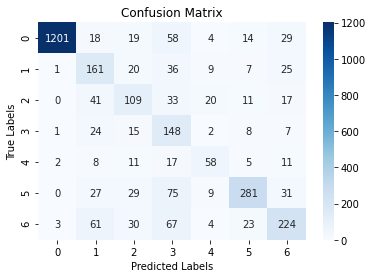

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for index, (inputs, labels) in enumerate(test_loader):
            print('\rEvaluating', f'{index}/{len(test_loader)}', end='')
            output = model(inputs.to(device))
            y_pred.extend(torch.argmax(output, axis=-1).tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print('f1_macro:', f1_score(y_true, y_pred, average='macro'))
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
evaluate(efficientnet_model, valloader)

Evaluating 753/754Classification Report:
f1_macro: 0.587019594708022
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1343
           1       0.41      0.51      0.45       259
           2       0.39      0.56      0.46       231
           3       0.38      0.64      0.47       205
           4       0.54      0.43      0.48       112
           5       0.78      0.60      0.68       452
           6       0.70      0.53      0.60       412

    accuracy                           0.72      3014
   macro avg       0.60      0.60      0.59      3014
weighted avg       0.77      0.72      0.74      3014



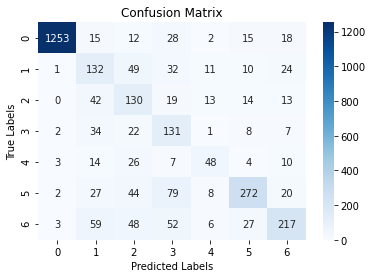

In [ ]:
model = torch.load(output_path + '/image_model_1617048331.pth')
model = model.to(device)
evaluate(model, valloader)

Evaluating 753/754Classification Report:
f1_macro: 0.5296134135095325
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1343
           1       0.38      0.31      0.34       259
           2       0.38      0.44      0.41       231
           3       0.27      0.70      0.39       205
           4       0.45      0.38      0.41       112
           5       0.78      0.58      0.66       452
           6       0.59      0.56      0.57       412

    accuracy                           0.67      3014
   macro avg       0.55      0.55      0.53      3014
weighted avg       0.73      0.67      0.69      3014



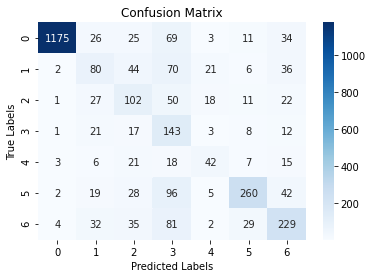

In [ ]:
model = torch.load(output_path + '/image_model_1617045194.pth')
model = model.to(device)
evaluate(model, valloader)

Evaluating 753/754Classification Report:
f1_macro: 0.43824744561454443
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1343
           1       0.34      0.17      0.23       259
           2       0.30      0.43      0.36       231
           3       0.21      0.77      0.33       205
           4       0.32      0.14      0.20       112
           5       0.77      0.46      0.58       452
           6       0.61      0.40      0.48       412

    accuracy                           0.61      3014
   macro avg       0.50      0.46      0.44      3014
weighted avg       0.69      0.61      0.63      3014



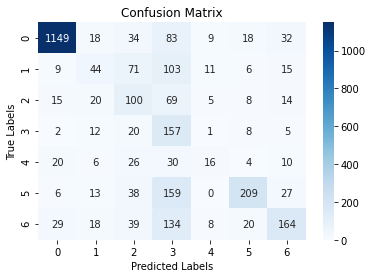

In [ ]:
model = torch.load(output_path + '/image_model_1617042056.pth')
model = model.to(device)
evaluate(model, valloader)

In [ ]:
import gc
gc.collect()

10526

In [ ]:
torch.cuda.memory_reserved() 

7168065536